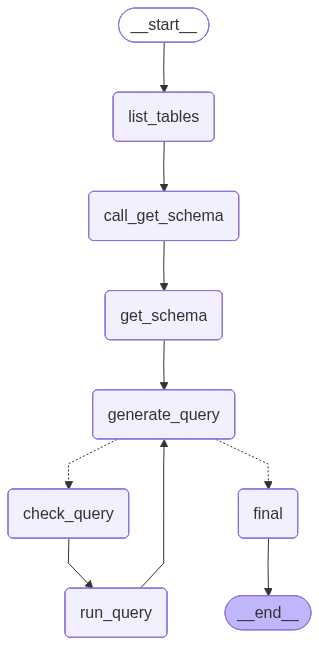

In [7]:
from load_llm import llm
from load_db import db

from langchain_community.agent_toolkits import SQLDatabaseToolkit

from typing import Literal

from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

model = llm("openai/gpt-oss-120b")
final_model = llm("llama-3.3-70b-versatile")

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = model.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = model.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(
    dialect=db.dialect
)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = model.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "final"
    else:
        return "check_query"


def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    response = final_model.invoke(
        [
            SystemMessage("Rewrite this in the voice of Al Roker"),
            HumanMessage(last_ai_message.content),
        ]
    )
    # overwrite the last AI message from the agent
    response.id = last_ai_message.id
    return {"messages": [response]}


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")
builder.add_node("final", call_final_model)

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query", should_continue, {"final": "final", "check_query": "check_query"}
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")
builder.add_edge("final", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
from typing import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain.schema.runnable.config import RunnableConfig
from langchain_core.messages import HumanMessage

import chainlit as cl


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]
model = ChatGroq(model="openai/gpt-oss-120b", temperature=0)
final_model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

model = model.bind_tools(tools)
# NOTE: this is where we're adding a tag that we'll can use later to filter the model stream events to only the model called in the final node.
# This is not necessary if you call a single LLM but might be important in case you call multiple models within the node and want to filter events
# from only one of them.
final_model = final_model.with_config(tags=["final_node"])
tool_node = ToolNode(tools=tools)

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage


def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "final"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    response = final_model.invoke(
        [
            SystemMessage("Rewrite this in the voice of Al Roker"),
            HumanMessage(last_ai_message.content),
        ]
    )
    # overwrite the last AI message from the agent
    response.id = last_ai_message.id
    return {"messages": [response]}


builder = StateGraph(MessagesState)

builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
# add a separate final node
builder.add_node("final", call_final_model)

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    should_continue,
)

builder.add_edge("tools", "agent")
builder.add_edge("final", END)

graph = builder.compile()


@cl.on_message
async def on_message(msg: cl.Message):
    config = {"configurable": {"thread_id": cl.context.session.id}}
    cb = cl.LangchainCallbackHandler()
    final_answer = cl.Message(content="")

    for msg, metadata in graph.stream(
        {"messages": [HumanMessage(content=msg.content)]},
        stream_mode="messages",
        config=RunnableConfig(callbacks=[cb], **config),
    ):
        if (
            msg.content
            and not isinstance(msg, HumanMessage)
            and metadata["langgraph_node"] == "final"
        ):
            await final_answer.stream_token(msg.content)

    await final_answer.send()

In [4]:
if []:
    print("he")
else:
    print("llo")

llo
